# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import threatgraph
from scipy import stats

In [2]:
# Number of 'top domains'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,ludicrous-mac,misskitty-mac,boundless-mac,languid-mac,dgmac,castle3b7c9f,turing-minimacbook,rarb-mac,nervings-cb,essential-cb,...,elysium-mac,traverses-mac,LAPTOP-1I501C4U,essential-mac,abroad-android,mark-mac,dramatic-mac,daniel-chromebook,simon-macpro,score
codecademy.com,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
acm.org,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,6
order-order.com,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
monitis.com,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,3
newmindmedia.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
stockopedia.com,0,13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
ophan.co.uk,0,37,0,0,0,0,1,0,0,5,...,0,0,0,0,0,0,1,0,0,1144
botvrij.eu,0,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,9
cnn.net,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
angular.io,0,56,54,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,149


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'googleapis.com', ..., 'stfi.re',
       'dpd.co.uk', 'rome2rio.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite domains by device

In [9]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['ludicrous-mac', array(['in-addr.arpa', 'google.com', 'apple.com', ...,
         'ugyuyhenzyssb.openvpn', 'dronebl.org', 'yelowsoft.com'],
        dtype=object)],
 ['misskitty-mac',
  array(['google.com', 'akadns.net', 'gstatic.com', ..., 'adicio.com',
         'silktide.com', 'mbww.com'], dtype=object)],
 ['boundless-mac',
  array(['google.com', 'in-addr.arpa', 'apple.com', ..., 'tradablebits.com',
         'vidssp.com', 'yelowsoft.com'], dtype=object)],
 ['languid-mac',
  array(['google.com', 'apple.com', 'in-addr.arpa', ..., 'hijinksensue.com',
         'rstudio.com', 'yelowsoft.com'], dtype=object)],
 ['dgmac', array(['google.com', 'apple.com', 'clubhouse.io', ..., 'betrad.com',
         'ugyuyhenzyssb.openvpn', 'yelowsoft.com'], dtype=object)],
 ['castle3b7c9f', array(['netgear.com', 'codecademy.com', 'konduit.me', ...,
         'phiphiohara.com', 'klnb.com', 'yelowsoft.com'], dtype=object)],
 ['turing-minimacbook',
  array(['google.com', 'apple.com', 'akadns.net', ..., 'sitepoi

In [10]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi..."
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap..."
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous..."
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic...."
dgmac,"[google.com, apple.com, clubhouse.io, trustnet..."
castle3b7c9f,"[netgear.com, codecademy.com, konduit.me, patc..."
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar..."
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap..."
nervings-cb,"[google.com, clubhouse.io, googleapis.com, gst..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap...",0.47
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",0.28
minesweepers-mac,"[google.com, github.com, in-addr.arpa, clubhou...",0.25
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.23
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.23
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.22
dramatic-mac,"[google.com, apple.com, rbxcdn.com, amazonaws....",0.19
mark-mac,"[facebook.com, virustotal.com, google.com, twi...",0.18
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",0.18


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [14]:
df3

,domains,ludicrous-mac,misskitty-mac,boundless-mac,languid-mac,dgmac,castle3b7c9f,turing-minimacbook,rarb-mac,nervings-cb,...,calcannea-cb,elysium-mac,traverses-mac,LAPTOP-1I501C4U,essential-mac,abroad-android,mark-mac,dramatic-mac,daniel-chromebook,simon-macpro
device,,,,,,,,,,,,,,,,,,,,,
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi...",1.00,0.24,0.61,0.62,0.98,0.98,0.76,0.95,0.78,...,0.83,0.64,0.98,0.84,0.98,0.95,0.65,0.59,0.98,0.80
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap...",0.24,1.00,0.37,0.35,0.25,0.22,0.32,0.26,0.36,...,0.31,0.31,0.23,0.29,0.23,0.26,0.31,0.28,0.24,0.32
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.61,0.37,1.00,0.67,0.62,0.59,0.64,0.63,0.67,...,0.68,0.65,0.60,0.67,0.60,0.63,0.66,0.61,0.61,0.65
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.62,0.35,0.67,1.00,0.62,0.60,0.69,0.63,0.67,...,0.67,0.70,0.61,0.69,0.61,0.64,0.67,0.64,0.62,0.69
dgmac,"[google.com, apple.com, clubhouse.io, trustnet...",0.98,0.25,0.62,0.62,1.00,0.97,0.77,0.94,0.79,...,0.84,0.65,0.97,0.85,0.97,0.95,0.66,0.59,0.97,0.80
castle3b7c9f,"[netgear.com, codecademy.com, konduit.me, patc...",0.98,0.22,0.59,0.60,0.97,1.00,0.75,0.93,0.77,...,0.82,0.62,0.98,0.83,0.99,0.94,0.63,0.58,0.97,0.78
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",0.76,0.32,0.64,0.69,0.77,0.75,1.00,0.77,0.76,...,0.78,0.69,0.76,0.78,0.75,0.77,0.70,0.64,0.76,0.81
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",0.95,0.26,0.63,0.63,0.94,0.93,0.77,1.00,0.78,...,0.84,0.65,0.94,0.84,0.94,0.93,0.67,0.60,0.94,0.80
nervings-cb,"[google.com, clubhouse.io, googleapis.com, gst...",0.78,0.36,0.67,0.67,0.79,0.77,0.76,0.78,1.00,...,0.85,0.68,0.77,0.82,0.77,0.80,0.69,0.63,0.78,0.79


## Plot heatmap

In [15]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

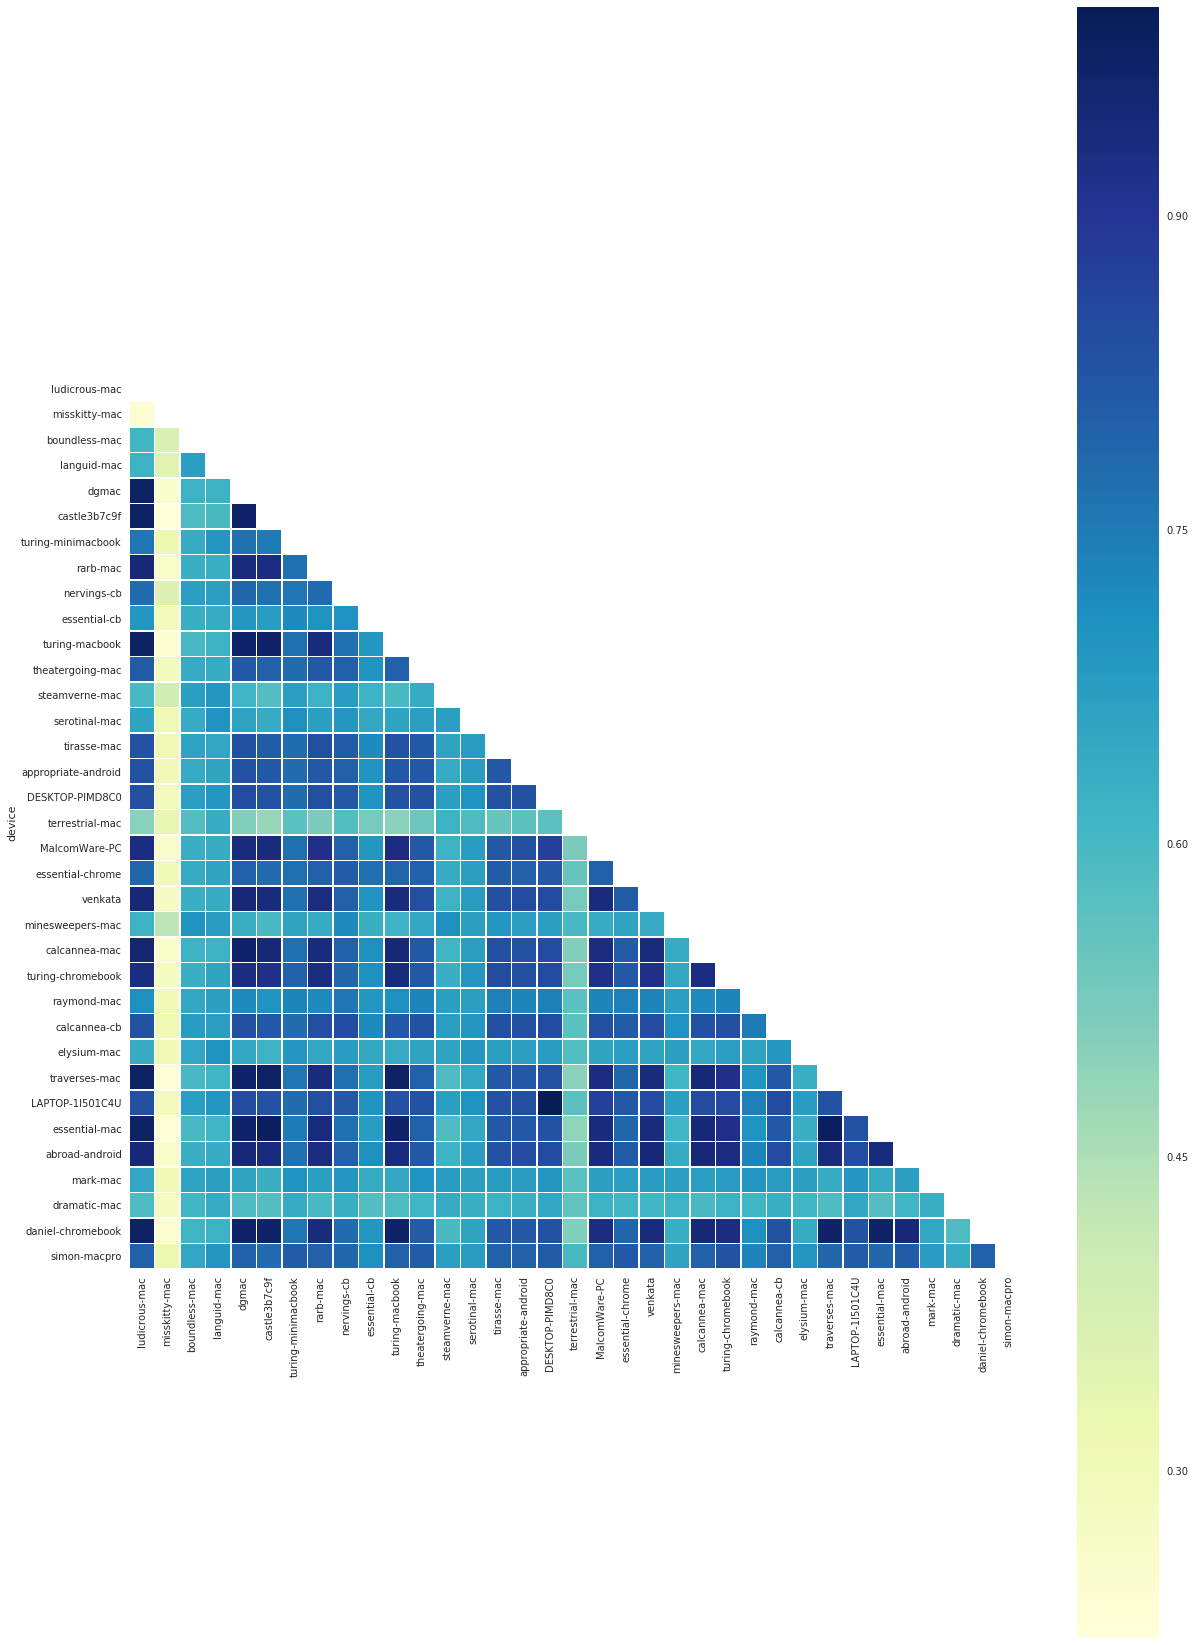

In [16]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [17]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [18]:
correlator("abcde", "abcdefg")

1.0

In [19]:
# This can be slow
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: correlator(domains, x)).round(6)
df3

,domains,ludicrous-mac,misskitty-mac,boundless-mac,languid-mac,dgmac,castle3b7c9f,turing-minimacbook,rarb-mac,nervings-cb,...,calcannea-cb,elysium-mac,traverses-mac,LAPTOP-1I501C4U,essential-mac,abroad-android,mark-mac,dramatic-mac,daniel-chromebook,simon-macpro
device,,,,,,,,,,,,,,,,,,,,,
ludicrous-mac,"[in-addr.arpa, google.com, apple.com, utun1.vi...",1.000000,0.171859,0.690639,0.700817,0.987471,0.976724,0.773840,0.950032,0.751090,...,0.840045,0.694803,0.987349,0.820489,0.979219,0.947181,0.684559,0.681968,0.987348,0.834383
misskitty-mac,"[google.com, akadns.net, gstatic.com, googleap...",0.171859,1.000000,0.242603,0.199901,0.187917,0.201381,0.273141,0.233150,0.293523,...,0.254761,0.235069,0.195302,0.236715,0.197702,0.204710,0.165265,0.198062,0.199154,0.252155
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.690639,0.242603,1.000000,0.830070,0.679163,0.698948,0.774719,0.712474,0.795983,...,0.752619,0.835851,0.699274,0.728252,0.699114,0.698793,0.836085,0.787188,0.699740,0.776867
languid-mac,"[google.com, apple.com, in-addr.arpa, gstatic....",0.700817,0.199901,0.830070,1.000000,0.688840,0.649351,0.795529,0.716917,0.797843,...,0.789895,0.839115,0.705923,0.794297,0.686291,0.666424,0.712632,0.803194,0.706839,0.782062
dgmac,"[google.com, apple.com, clubhouse.io, trustnet...",0.987471,0.187917,0.679163,0.688840,1.000000,0.975316,0.764235,0.953355,0.787764,...,0.833155,0.686300,0.983778,0.812009,0.977369,0.948135,0.674837,0.678308,0.986121,0.835071
castle3b7c9f,"[netgear.com, codecademy.com, konduit.me, patc...",0.976724,0.201381,0.698948,0.649351,0.975316,1.000000,0.784612,0.943196,0.792549,...,0.857853,0.701399,0.982965,0.850475,0.995718,0.948041,0.689417,0.664866,0.977742,0.819858
turing-minimacbook,"[google.com, apple.com, akadns.net, in-addr.ar...",0.773840,0.273141,0.774719,0.795529,0.764235,0.784612,1.000000,0.820016,0.825973,...,0.833339,0.761426,0.781317,0.815893,0.783347,0.753692,0.825935,0.777413,0.783210,0.870266
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",0.950032,0.233150,0.712474,0.716917,0.953355,0.943196,0.820016,1.000000,0.841951,...,0.886919,0.715190,0.940533,0.886432,0.946418,0.913466,0.734054,0.704665,0.947896,0.855373
nervings-cb,"[google.com, clubhouse.io, googleapis.com, gst...",0.751090,0.293523,0.795983,0.797843,0.787764,0.792549,0.825973,0.841951,1.000000,...,0.891868,0.764427,0.781903,0.849215,0.792028,0.831985,0.797200,0.743002,0.782188,0.874751


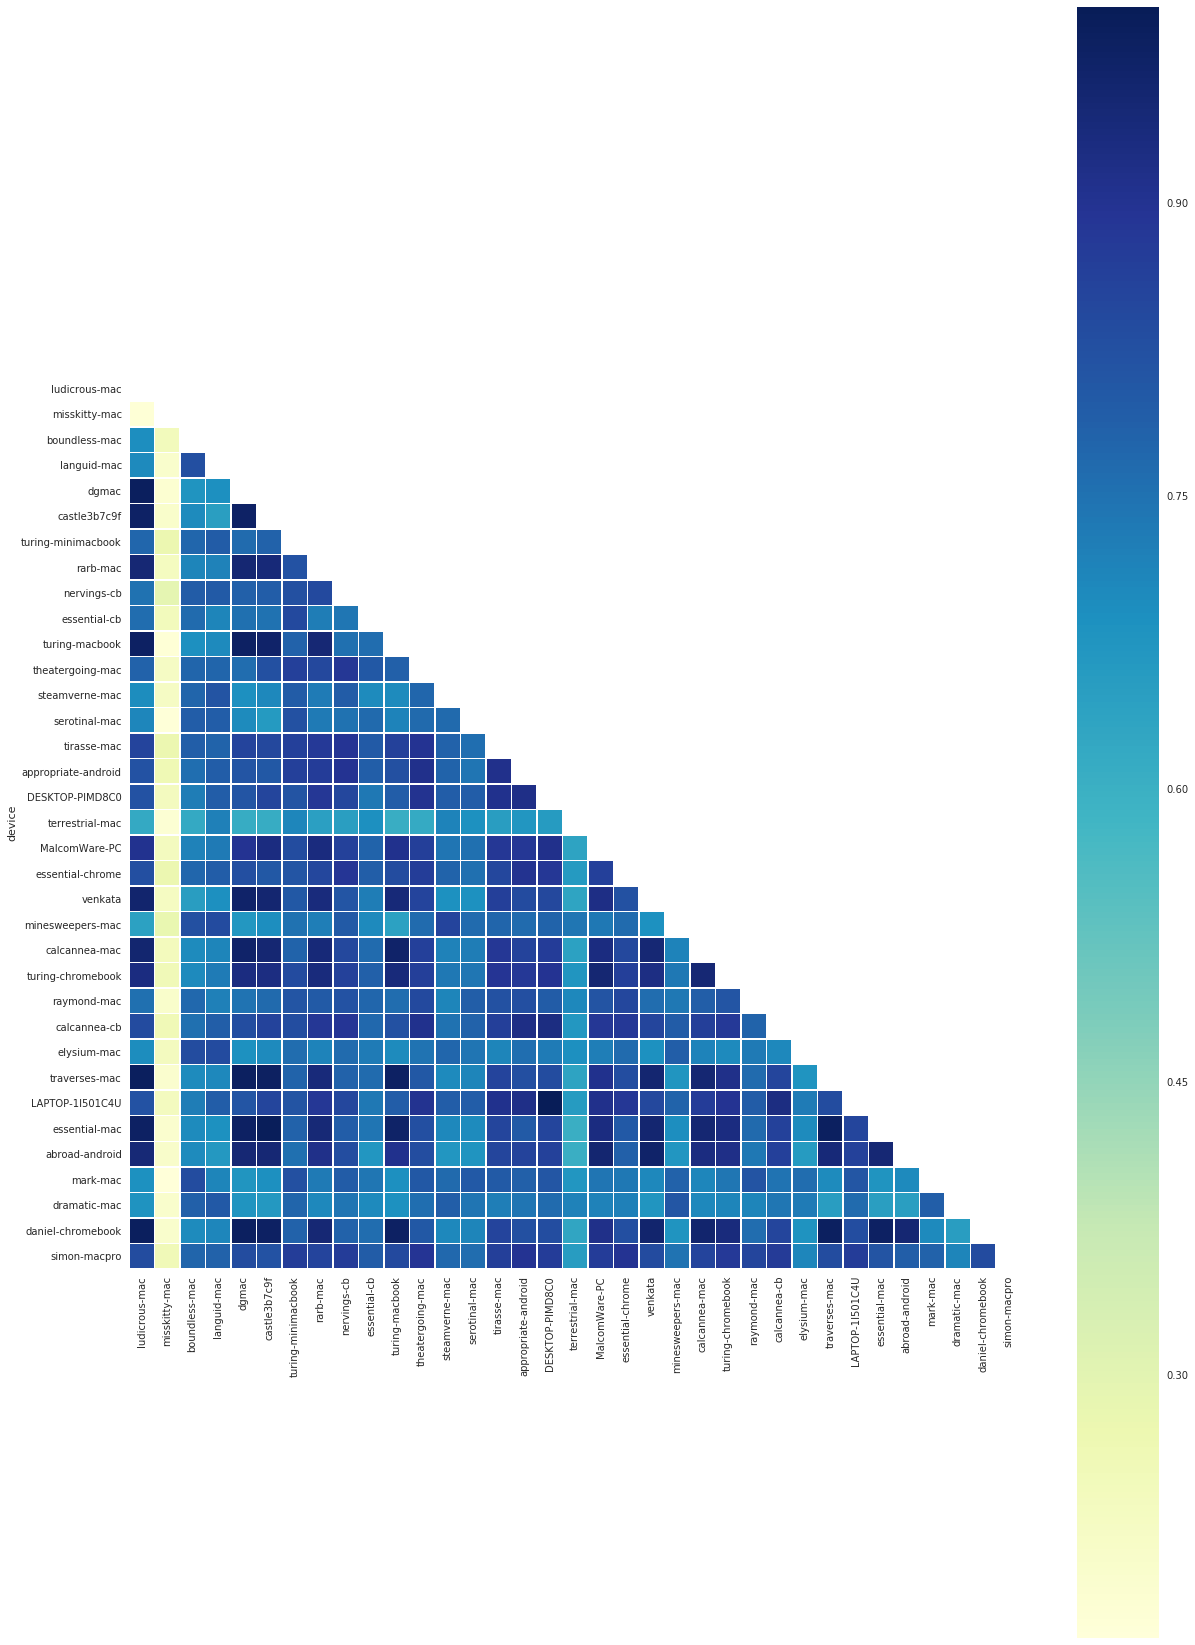

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()